In [8]:
library(tidyverse)
library(tidymodels)
library(repr)
library(rvest)
library(stringr)
library(dbplyr)
library(DBI)
library(RPostgres)
library(lubridate)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

# Algerian Forest Fires and the Weather
## Background and Introduction:
As our climate changes, and forest fires become more of a danger to humans all around the world, it is more and more important to understand the conditions which can lead to their ignition. Due to increasing temperatures, summer temperatures have been increasing, resulting in dryer heat (lower humidity), dryer forests, which lead to easier ignition. Rising temperatures result in the the unequality of temperature between the sky and the earth, leading to further likelihood of lightning--along with human campfires, cigarettes, and fireworks alike, these igniting forces are sure to lead to forest fires. ([Source](https://climateatlas.ca/forest-fires-and-climate-change#:~:text=Dry%20heat%20helps%20create%20more,rising%20temperature%20of%20the%20Arctic.))


## Our research question:  What are the weather conditions needed to result in a forest fire in the Algerian Forest Areas?
## The dataset:
Our dataset, "The Algerian Forest Fires Dataset" ([link to dataset](https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++)) provides information on forest fires in two areas: the Sidi-Bel Abbas and Bejaia regions. The data was taken from June 2012 to September 2012, and contains information on the following data:

1. Date: (DD/MM/YYYY) Day, month ('june' to 'september'), year (2012)
Weather data observations
2. Temp: temperature noon (temperature max) in Celsius degrees: 22 to 42
3. RH: Relative Humidity in %: 21 to 90
4. Ws: Wind speed in km/h: 6 to 29
5. Rain: total day in mm: 0 to 16.8
FWI Components
6. Fine Fuel Moisture Code (FFMC) index from the FWI system: 28.6 to 92.5
7. Duff Moisture Code (DMC) index from the FWI system: 1.1 to 65.9
8. Drought Code (DC) index from the FWI system: 7 to 220.4
9. Initial Spread Index (ISI) index from the FWI system: 0 to 18.5
10. Buildup Index (BUI) index from the FWI system: 1.1 to 68
11. Fire Weather Index (FWI) Index: 0 to 31.1
12. Classes: two classes, namely Fire and Not Fire

Vector 1 is the date, 2-5 are all weather based observations, vectors 6-11 are all "Fire Weather Index" components, and vector 12 is whether there was a fire or not in the area.
Fire Weather Index, or FWI, is a general measure used to predict the intensity of a potential fire in the area, and takes into account each component when calculating this. 

Warning message:
“18 parsing failures.
row   col   expected                        actual                                                                                                       file
123 day   an integer Sidi-Bel Abbes Region Dataset 'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
123 NA    14 columns 1 columns                     'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
124 day   an integer day                           'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
124 month an integer month                         'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
124 year  an integer year                          'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
... ..... ...

day,month,Temperature,FWI,RH,Ws,Rain,Classes
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,6,29,0.5,57,18,0.0,not fire
2,6,29,0.4,61,13,1.3,not fire
3,6,26,0.1,82,22,13.1,not fire
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,9,27,0.2,87,29,0.5,not fire
29,9,24,0.7,54,18,0.1,not fire
30,9,24,0.5,64,15,0.2,not fire


`summarise()` ungrouping output (override with `.groups` argument)



Classes,n,average_temp,average_FWI
<fct>,<int>,<dbl>,<dbl>
not fire,80,29.97500,0.92375
fire,103,33.70874,11.84854


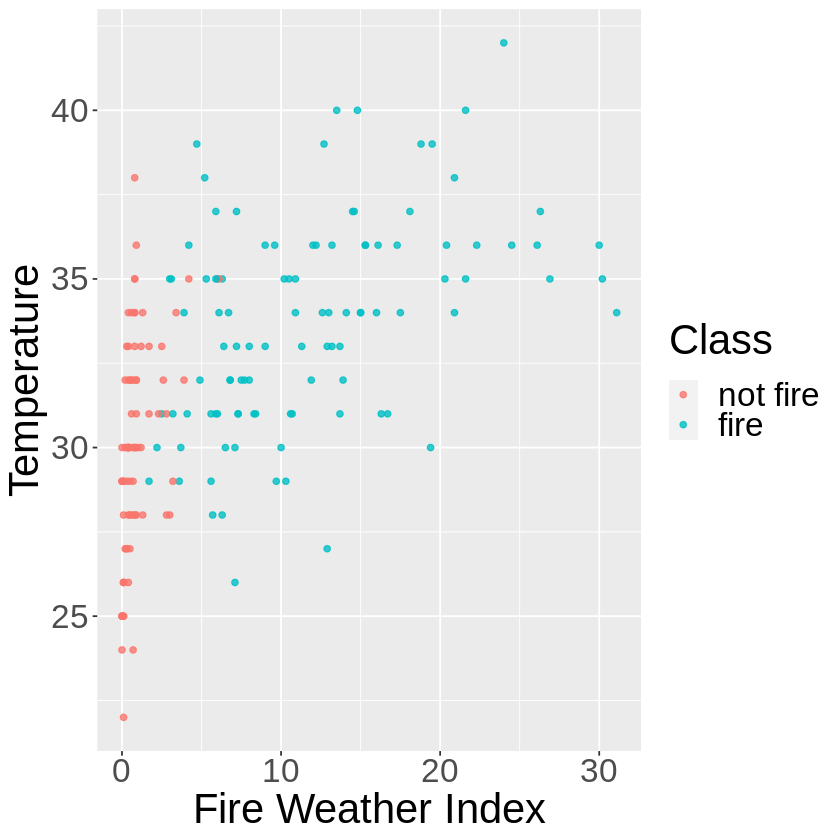

In [9]:

# Title: Factors Contributing to Algerian Forest Fires
# Introduction:
forest_fires_untidy <- read_csv(file = "https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv", 
                                skip = 1, col_names = TRUE, col_types = cols_only(
                                      day = col_integer(),
                                      month = col_integer(),
                                      year = col_integer(),
                                      Temperature = col_double(),
                                      RH = col_double(),
                                      Ws = col_double(),
                                      Rain = col_double(),
                                      FFMC = col_double(),
                                      DMC = col_double(),
                                      DC = col_double(),
                                      ISI = col_double(),
                                      BUI = col_double(),
                                      FWI = col_double(),
                                      Classes = col_character()))  
  
bejaia_region <- forest_fires_untidy %>%
    slice(1:122) %>%
    mutate(region = "bejaia")

sidi_bel_region <- forest_fires_untidy %>%
    slice(125:246) %>%
    mutate(region = "sidi bel abbes")

forest_fire_data <- rbind(bejaia_region, sidi_bel_region) 

fire_data <- forest_fire_data %>%
     filter(!is.na(Classes)) %>%
     select(day, month, Temperature, FWI, RH, Ws, Rain, Classes) %>%
     mutate(Classes = as_factor(Classes))

fire_data

set.seed(1)
fire_split <- initial_split(fire_data, prop = 0.75, strata = Classes)
fire_train <- training(fire_split)
fire_test <- testing(fire_split)

fire_recipe <- recipe(Classes ~ month + Temperature + FWI, data = fire_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

set.seed(1)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_fit <- workflow() %>%
    add_recipe(fire_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = fire_train)

fire_test_predictions <- predict(knn_fit, fire_test) %>%
    bind_cols(fire_test)

fire_train %>%
    group_by(Classes) %>%
    summarize(n = n(),
    average_temp = mean(Temperature),
    average_FWI = mean(FWI))

fire_test_plot <- fire_train %>%
    ggplot(aes(x = FWI, y = Temperature, color = Classes))+
    geom_point(alpha = 0.8)+
    scale_fill_distiller(palette = "YlOrRd") +
    labs(x = "Fire Weather Index", y = "Temperature", color = "Class")+
    theme(text = element_text(size = 25))
    
#fire_test_plot <- fire_test_plot +
    

fire_test_plot

# Methods
For our analysis, we will not be looking at any of the individual FWI components and instead will be looking at the weather data observations (Temperature, Relative Humidity (RH), Wind speed (WS), Rain, FWI Components as well as the overall FWI). We are not interested in the potential of intensity, rather we are interested in the contribution of the weather in forest fire ignition, and how this might correlate with FWI as a whole.
Furthermore, as the data was all taken from a single year, we do not select the year column as this information is redundant.

For our visualization, we plan on doing a scattergraph with temperature on the y-axis and then FWI on the x-axis, and coloured by whether or not each point.

For another possible visualization, we plan on making a grid with numerous graphs. FWI will be on the x-axis for one, while, all other predictors on their own visualization on the y-axis. Each will be coloured by whether or not each point was a fire.

# Expected outcomes and significance:
We aim to figure out what are the key factors that might lead to the occurrence of the forest fire. We expect that as the temperature increases, forest fires are more likely to happen. Based on a first look at the dataset, we expect that the fire has a very high possibility to exist when the temperature is over 30 celsius degrees. 

On the other hand, FWI(Fire Weather Index) is also an important factor because we observe that the fire will not exist when FWI is below 1 in most cases, and does exist when it is above 1. 

Our findings are significant as they will serve to help predict environmental reasons which will cause the forest fires, therefore tracking days of potential danger of fires, and act accordingly. 

Some future questions are:
- What are the potential reasons that can cause FWI(Fire Weather Index) to increase? 
- How do the factors and levels of those factors that contribute to forest fires in Algeria compare with the same factor levels elsewhere?
- How might we combat these weather changes in to prevent forest fires?